In [151]:
%load_ext autoreload
%autoreload 2
%aimport


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [152]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

import matplotlib.pyplot as plt

from multicam.plotting import set_rc


In [153]:

metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


## Run pipelien to extract DMO and Hydro catalogs

In [154]:
from multicam.tng.utils import hydro_dm_match_pipeline

data = hydro_dm_match_pipeline(present_snapfile, present_dark_snapfile, trees_file, dark_trees_file, metadata_file, color_file, mass_bin=(12.8, 13.1), mbin_fudge = 0.2)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
100%|██████████| 3293/3293 [00:28<00:00, 117.59it/s]
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:330: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat["vmax/vvir"] = get_vmax_over_vvir(cat)


In [155]:
cat, dcat = data['cat'], data['dcat']
m_peak, dm_peak = data['m_peak'], data['dm_peak']
scales = data['scales']

len(cat), len(dcat)


(2931, 2931)

In [156]:
# avoid correlations and other issues with very last bin which is always 1
m_peak = m_peak[:, :-1]
dm_peak = dm_peak[:, :-1]
scales = scales[:-1]

m_peak.shape, dm_peak.shape, scales.shape


((2931, 79), (2931, 79), (79,))

## Correlations with DMO properties

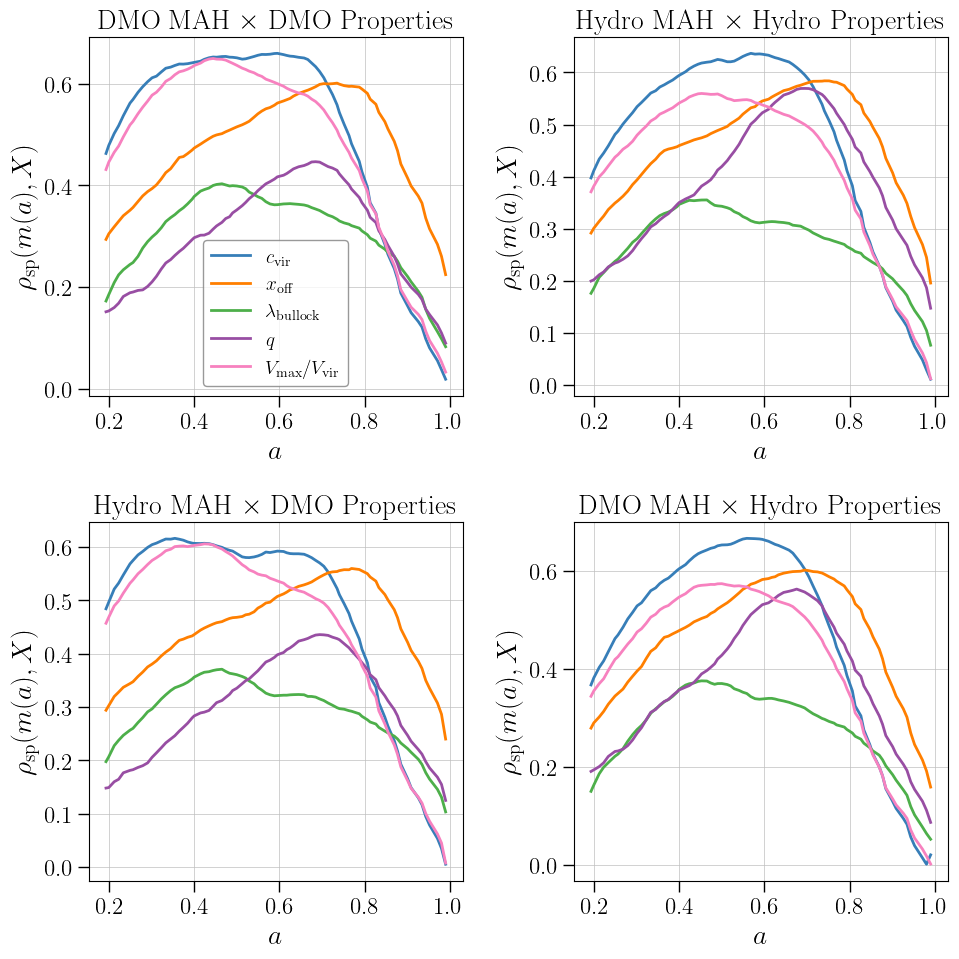

In [157]:
from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG

set_rc()

dmo_params = ['cvir', 'X_off_DM', 'Spin_Bullock_DM', 'q_DM', 'vmax/vvir']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

cat_peak_combs = [
                (dcat, dm_peak), 
                (cat, m_peak), 
                (dcat, m_peak),
                (cat, dm_peak),
            ]
titles = [
          r'\rm DMO MAH $\times$ DMO Properties', 
          r'\rm Hydro MAH $\times$ Hydro Properties', 
          r'\rm Hydro MAH $\times$ DMO Properties', 
          r'\rm DMO MAH $\times$ Hydro Properties'
        ]

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in dmo_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=LATEX_PARAMS_TNG[param])

for ii, (ax, title) in enumerate(zip(axes, titles)):
    if ii == 0:
        ax.legend(prop={'size': 14})
    ax.set_xlabel(r'$a$')
    ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    ax.set_title(title, fontsize='medium')


plt.tight_layout()


## Correlations with Hydro properties

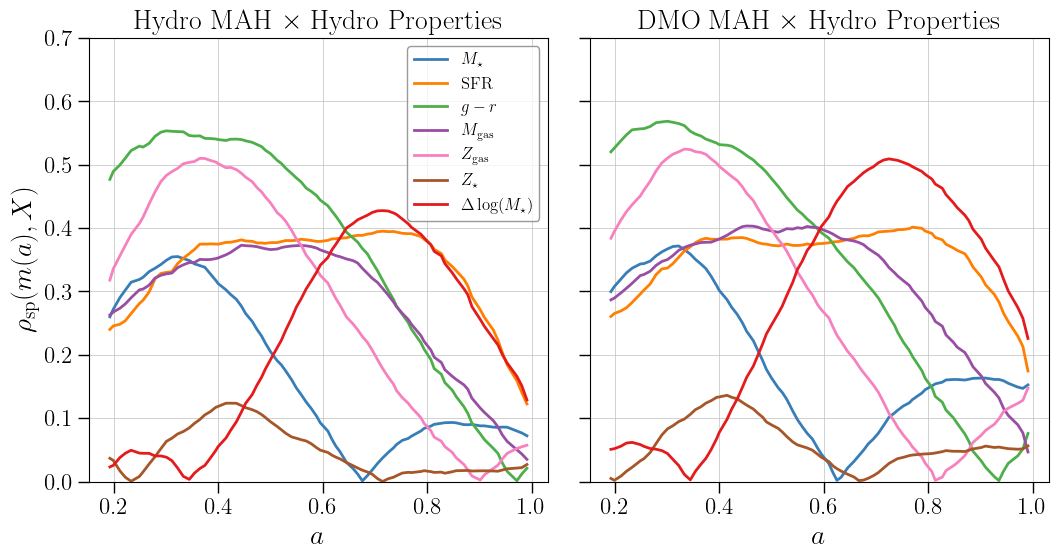

In [146]:
from multicam.correlations import spearmanr
from multicam.plotting import LATEX_PARAMS_TNG

set_rc()

hydro_params = ['Mstar_vir', 'SFR_vir', 'g-r', 'Mgas_vir', 'Zgas_vir', 'Zstar_vir', 'msmhmr' ]



fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
axes = axes.flatten()

cat_peak_combs = [(cat, dm_peak), (cat, m_peak)]
titles = [r'\rm Hydro MAH $\times$ Hydro Properties', r'\rm DMO MAH $\times$ Hydro Properties']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in hydro_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=LATEX_PARAMS_TNG[param])

for ii, (ax, title) in enumerate(zip(axes, titles)):
    if ii == 0:
        ax.legend(prop={'size': 12}, loc='best')
        ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    ax.set_xlabel(r'$a$')
    ax.set_title(title, fontsize='medium')
    ax.set_ylim(0, 0.7)


plt.tight_layout()


## MultiCAM prediction and correlations of Hydro and DMO params

In [50]:
from multicam.models import MultiCAM 

n_features = m_peak.shape[1]
n_targets = len(dmo_params) + len(hydro_params)
all_params = dmo_params + hydro_params


model_hydro = MultiCAM(n_features, n_targets)
model_dmo = MultiCAM(n_features, n_targets)

model_hydro.fit(m_peak, cat[all_params].values)
model_dmo.fit(dm_peak, cat[all_params].values)


In [52]:
# now use all dmo properties (from dmo catalog) to predict hydro
n_features = dm_peak.shape[1] + len(dmo_params)
n_targets = len(hydro_params)
x = np.concatenate([dm_peak, dcat[dmo_params].values], axis=1)
y = cat[hydro_params].values
model_dmo_all = MultiCAM(n_features, n_targets)

model_dmo_all.fit(x, y)


In [53]:
hydro_pred = model_hydro.predict(m_peak)
dmo_pred = model_dmo.predict(dm_peak)
dmo_all_pred = model_dmo_all.predict(x)


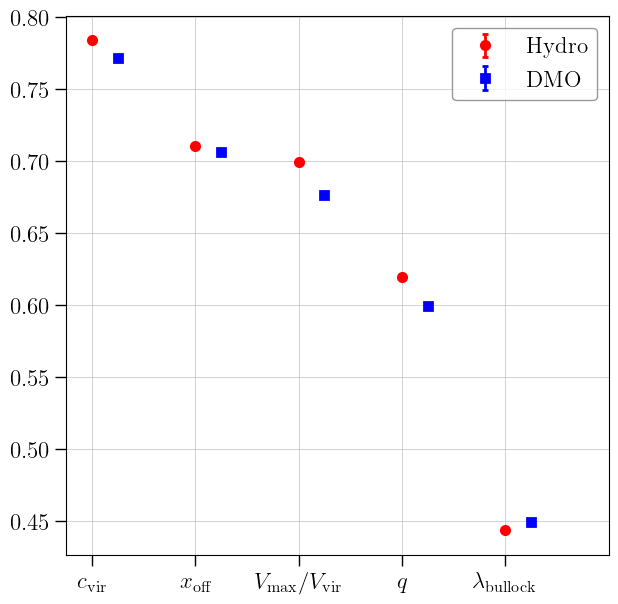

In [61]:
# DMO prediction of hydro sims

# compare spearman correlation plot of predictions from each model 
# x-axis is label with property predicted, y-axis is spearman r of prediction and truth
from multicam.correlations import spearmanr
from multicam.plotting import metrics_plot

set_rc()

# update rc plots fontsize 

n_dmo_params = len(dmo_params)

fig, ax = plt.subplots(1,1, figsize=(7, 7))

# setup latex params in plot
plot_params = [LATEX_PARAMS_TNG[param] for param in dmo_params]

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
for ii in range(n_dmo_params):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))

# order by highest correlation to lowest
sort_idx = np.argsort(hydro_corrs)[::-1]
hydro_corrs = np.array(hydro_corrs)[sort_idx]
dmo_corrs = np.array(dmo_corrs)[sort_idx]
plot_params = np.array(plot_params)[sort_idx]

metrics_plot(ax, hydro_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm Hydro', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO', x_bias=0.25, m='s', c='b')

plt.legend(loc='best')


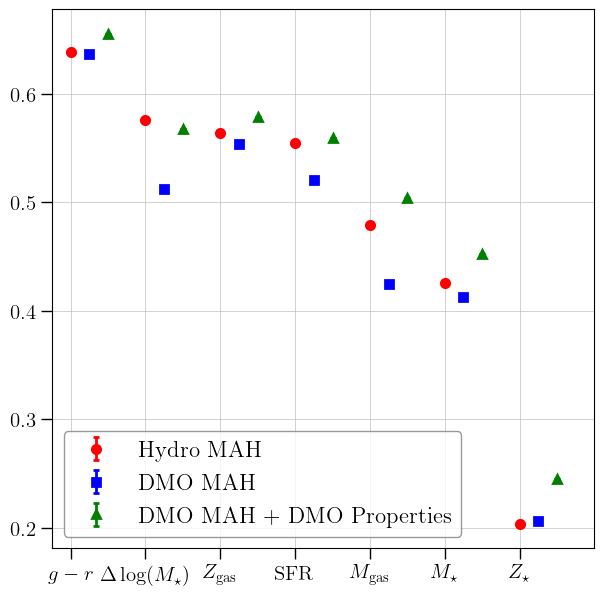

In [72]:
# Hydro prediction 

set_rc()

n_dmo_params = len(dmo_params)
n_hydro_params = len(hydro_params)

fig, ax = plt.subplots(1,1, figsize=(7, 7))

# setup latex params in plot
plot_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
dmo_all_corrs = []

for ii in range(n_dmo_params, n_hydro_params + n_dmo_params):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))
    dmo_all_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_all_pred[:, ii - n_dmo_params]))

# order by highest correlation to lowest
sort_idx = np.argsort(hydro_corrs)[::-1]

hydro_corrs = np.array(hydro_corrs)[sort_idx]
dmo_corrs = np.array(dmo_corrs)[sort_idx]
dmo_all_corrs = np.array(dmo_all_corrs)[sort_idx]
plot_params = np.array(plot_params)[sort_idx]

metrics_plot(ax, hydro_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm Hydro MAH', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO MAH', x_bias=0.25, m='s', c='b')
metrics_plot(ax, dmo_all_corrs, np.zeros((len(hydro_corrs),)), plot_params, r'\rm DMO MAH $+$ DMO Properties', x_bias=0.5, m='^', c='g') 

ax.tick_params(axis='both', labelsize=15)

plt.legend(loc='best')


## T_Star correlations

In [77]:
[c for c in cat.columns if 'tstar' in c] 


['tstar_vir',
 'tstar_200c',
 'tstar_500c',
 'tstar_2500c',
 'tstar_10pkpc',
 'tstar_30pkpc',
 'tstar_100pkpc']

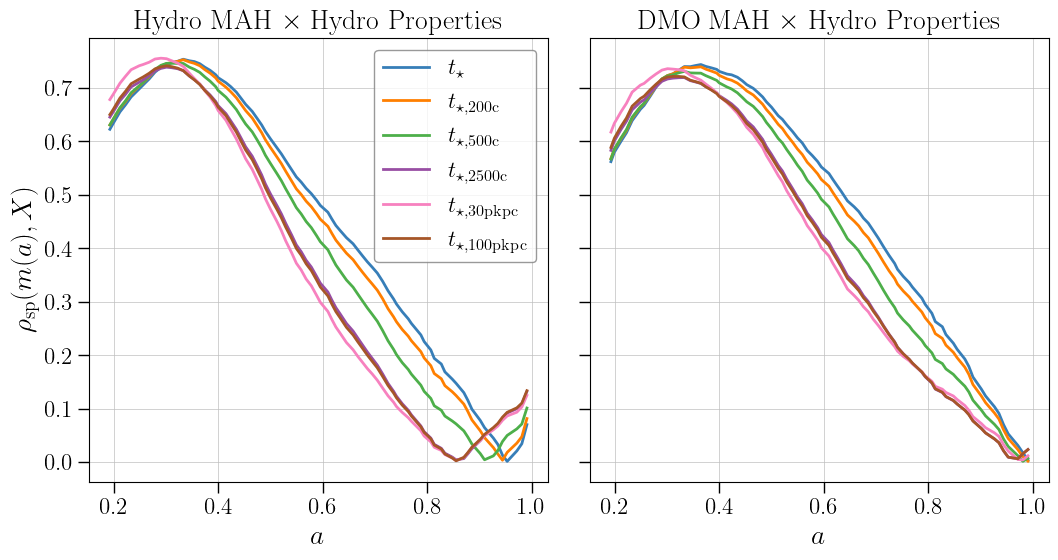

In [148]:
from multicam.plotting import LATEX_PARAMS_TNG
from multicam.correlations import spearmanr

t_params = ['tstar_vir', 'tstar_200c', 'tstar_500c', 'tstar_2500c', 'tstar_30pkpc', 'tstar_100pkpc']

fig, axes = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
axes = axes.flatten()

cat_peak_combs = [(cat, m_peak), (cat, dm_peak)]
titles = [r'\rm Hydro MAH $\times$ Hydro Properties', r'\rm DMO MAH $\times$ Hydro Properties']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in t_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=LATEX_PARAMS_TNG[param])

for ii, (ax, title) in enumerate(zip(axes, titles)):
    if ii == 0:
        ax.legend(loc='best')
        ax.set_ylabel(r'$\rho_{\rm sp}(m(a), X)$')
    ax.set_xlabel(r'$a$')
    ax.set_title(title, fontsize='medium')


plt.tight_layout()


## 2D Correlations of Hydro Features (MultiCAM sampling)

In [136]:
from multicam.models import MultiCamSampling

hydro_params = ['Mstar_vir', 'SFR_vir', 'g-r', 'Mgas_vir', 'Zgas_vir', 'Zstar_vir', 'msmhmr' ]
n_targets = len(hydro_params)

dmodel = MultiCamSampling(79, n_targets)
model = MultiCamSampling(79, n_targets)
naive_model = MultiCamSampling(1, n_targets)

# remove nan's and inf's from data
hydro_cat = cat[hydro_params]
mask1 = np.isnan(hydro_cat.values).any(axis=1)
mask2 = np.isinf(hydro_cat.values).any(axis=1)
mask = mask1 | mask2


_dm_peak = dm_peak[~mask]
_m_peak = m_peak[~mask]

x1 = _dm_peak
x2 = _m_peak
x3 = _m_peak[:, [10]] # two random indices for x3
y = hydro_cat[:].values[~mask]

x1.shape, x2.shape, x3.shape, y.shape


((2640, 79), (2640, 79), (2640, 1), (2640, 7))

In [137]:
dmodel.fit(x1, y)
model.fit(x2, y)
naive_model.fit(x3, y)


In [103]:
y1 = dmodel.sample(x1, 1)[:, 0, :]
y2 = model.sample(x2, 1)[:, 0, :]
y3 = naive_model.sample(x3, 1)[:, 0, :]


In [138]:
hydro_params


['Mstar_vir', 'SFR_vir', 'g-r', 'Mgas_vir', 'Zgas_vir', 'Zstar_vir', 'msmhmr']

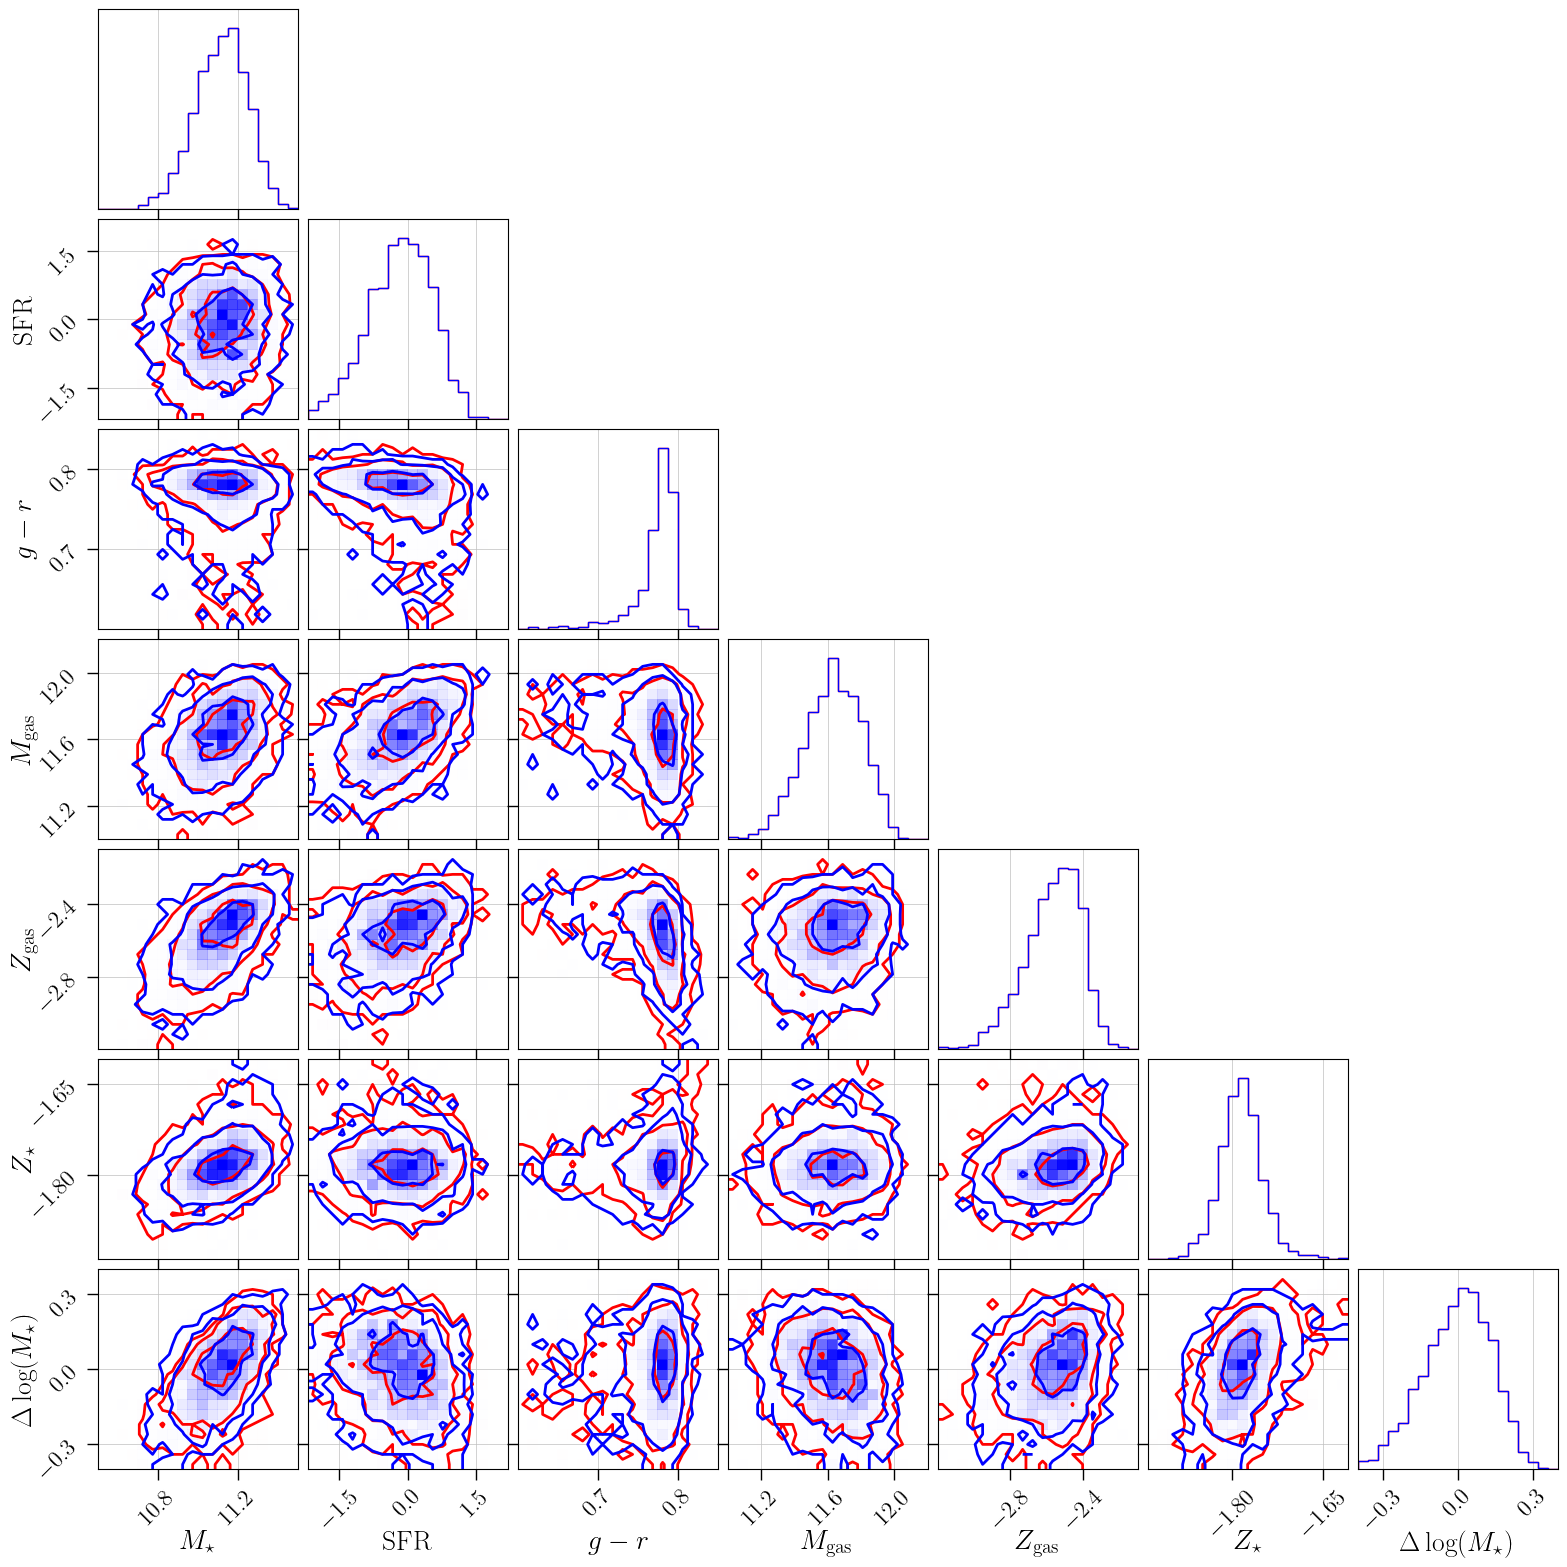

In [139]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 'Zgas_vir': (-3.2, -2.1), 'Zstar_vir': (-1.94, -1.61), 'msmhmr': (-0.4, 0.4)}
ranges = [param_ranges[param] for param in hydro_params]


# ranges = [(0.65, 1.15), (0.94, 1.1), (-1, 2.5), (0.6, 0.85), (-0.56, 0.4), (10.6, 11.5)]
# do_log = [True, True, True, False, False, False]
# y_log = [np.log10(y[:, ii]) if do_log[ii] else y[:, ii] for ii in range(len(ranges))]
# y_log = np.array(y_log).T
# y_log1 = [np.log10(y1[:, ii]) if do_log[ii] else y1[:, ii] for ii in range(len(ranges))]
# y_log1 = np.array(y_log1).T
# y_log2 = [np.log10(y2[:, ii]) if do_log[ii] else y2[:, ii] for ii in range(len(ranges))]
# y_log2 = np.array(y_log2).T

fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
fig = corner.corner(y1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)
# fig = corner.corner(y_log1, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', range=ranges, fig=fig)
# fig = corner.corner(y_log2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='g', range=ranges,fig=fig)


In [ ]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 'Zgas_vir': (-3.2, -2.1), 'Zstar_vir': (-1.94, -1.61), 'msmhmr': (-0.4, 0.4)}
ranges = [param_ranges[param] for param in hydro_params]


fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
fig = corner.corner(y2, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)


In [ ]:
# try with corner 
import corner
levels = [1 - np.exp(-(x**2) / 2) for x in [1, 2, 3]]
latex_hydro_params = [LATEX_PARAMS_TNG[param] for param in hydro_params]
param_ranges = {'Mstar_vir': (10.5, 11.5), 'SFR_vir': (-2.2, 2.2), 'g-r': (0.6, 0.85), 'Mgas_vir': (11.0, 12.2), 'Zgas_vir': (-3.2, -2.1), 'Zstar_vir': (-1.94, -1.61), 'msmhmr': (-0.4, 0.4)}
ranges = [param_ranges[param] for param in hydro_params]


fig = corner.corner(y, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='r', labels=latex_hydro_params, range=ranges)
fig = corner.corner(y3, max_n_ticks=3, plot_datapoints=False, levels=levels, bins=20, color='b', labels=latex_hydro_params, fig=fig, range=ranges)
